# Proof of Concept Model for Identifying Cancer Cells in H&E slide

## Background

- Dataset
    - [CAMELYON16](https://camelyon16.grand-challenge.org)
        - Challenge: Automated dectection of metastases from H&E whole-slide images (WSIs) of sentinel lymph nodes from breast cancer patients.
        - Winning approach from Beck et al. from HMS/BI/MIT
            - [results](https://camelyon16.grand-challenge.org/PerTeamResult/?id=BIDMC_CSAIL)
            - [presentation](https://camelyon16.grand-challenge.org/site/CAMELYON16/serve/public_html/Results/Presentations/Camelyon16_BIDMC_CSAIL.pdf/)
            - Uses transfer learning of [GoogLeNet](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf).
- Approach
    - [Image Segmentation to predict left ventrile from cardiac MRI scans](https://gist.github.com/ajsander/b65061d12f50de3cef5d#file-fcn_tutorial-ipynb)
        - Uses 8 layer Fully-convolutional network.
            - [presentation](http://tutorial.caffe.berkeleyvision.org/caffe-cvpr15-pixels.pdf)
            - [paper](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)

## Setup Environment

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import cv2


In [3]:
!nvidia-smi

Thu Jan 11 02:45:22 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970     Off  | 00000000:01:00.0  On |                  N/A |
| 34%   29C    P2    55W / 250W |    240MiB /  4036MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

GPU is fired up and ready to go.

## Load data

In [53]:
import os.path as osp
import openslide
from pathlib import Path
# print(openslide.__library_version__)

BASE_TRUTH_DIR = Path('/home/tee/Documents/thesis/camelyon16/center_3/')

slide_name ='Tumor_018.tif'
slide_path = str(BASE_TRUTH_DIR / slide_name)

truth_path = str(BASE_TRUTH_DIR / 'Tumor_018_Mask.tif')

slide = openslide.open_slide(slide_path)
truth = openslide.open_slide(truth_path)

"Original Slide dimensions %dx%d" % slide.dimensions


'Original Slide dimensions 97792x221184'

These slides are huge -- 21 billion pixels!  We'll break this huge image into 256x256x3 patches for training.

In [54]:
thumbnail = slide.get_thumbnail((slide.dimensions[0]/256, slide.dimensions[1]/256 )) 

thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(thumbnail);
ax[0].set_title('Slide %dx%d' % thumbnail.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails (downsampled 256x)');

Each pixel in these thumbnails corresponds to a 256x256 patch that can be used for training.  White areas in truth mask are cancer regions.

## Tissue area selection

We can use Otsu's method to find areas on slide with tissue.  Pixels with binary==False will be set of patches available for training.

In [55]:
from skimage.filters import threshold_otsu

img = np.array(thumbnail.convert('L')) # convert to grayscale
thresh = threshold_otsu(img)
binary = img > thresh

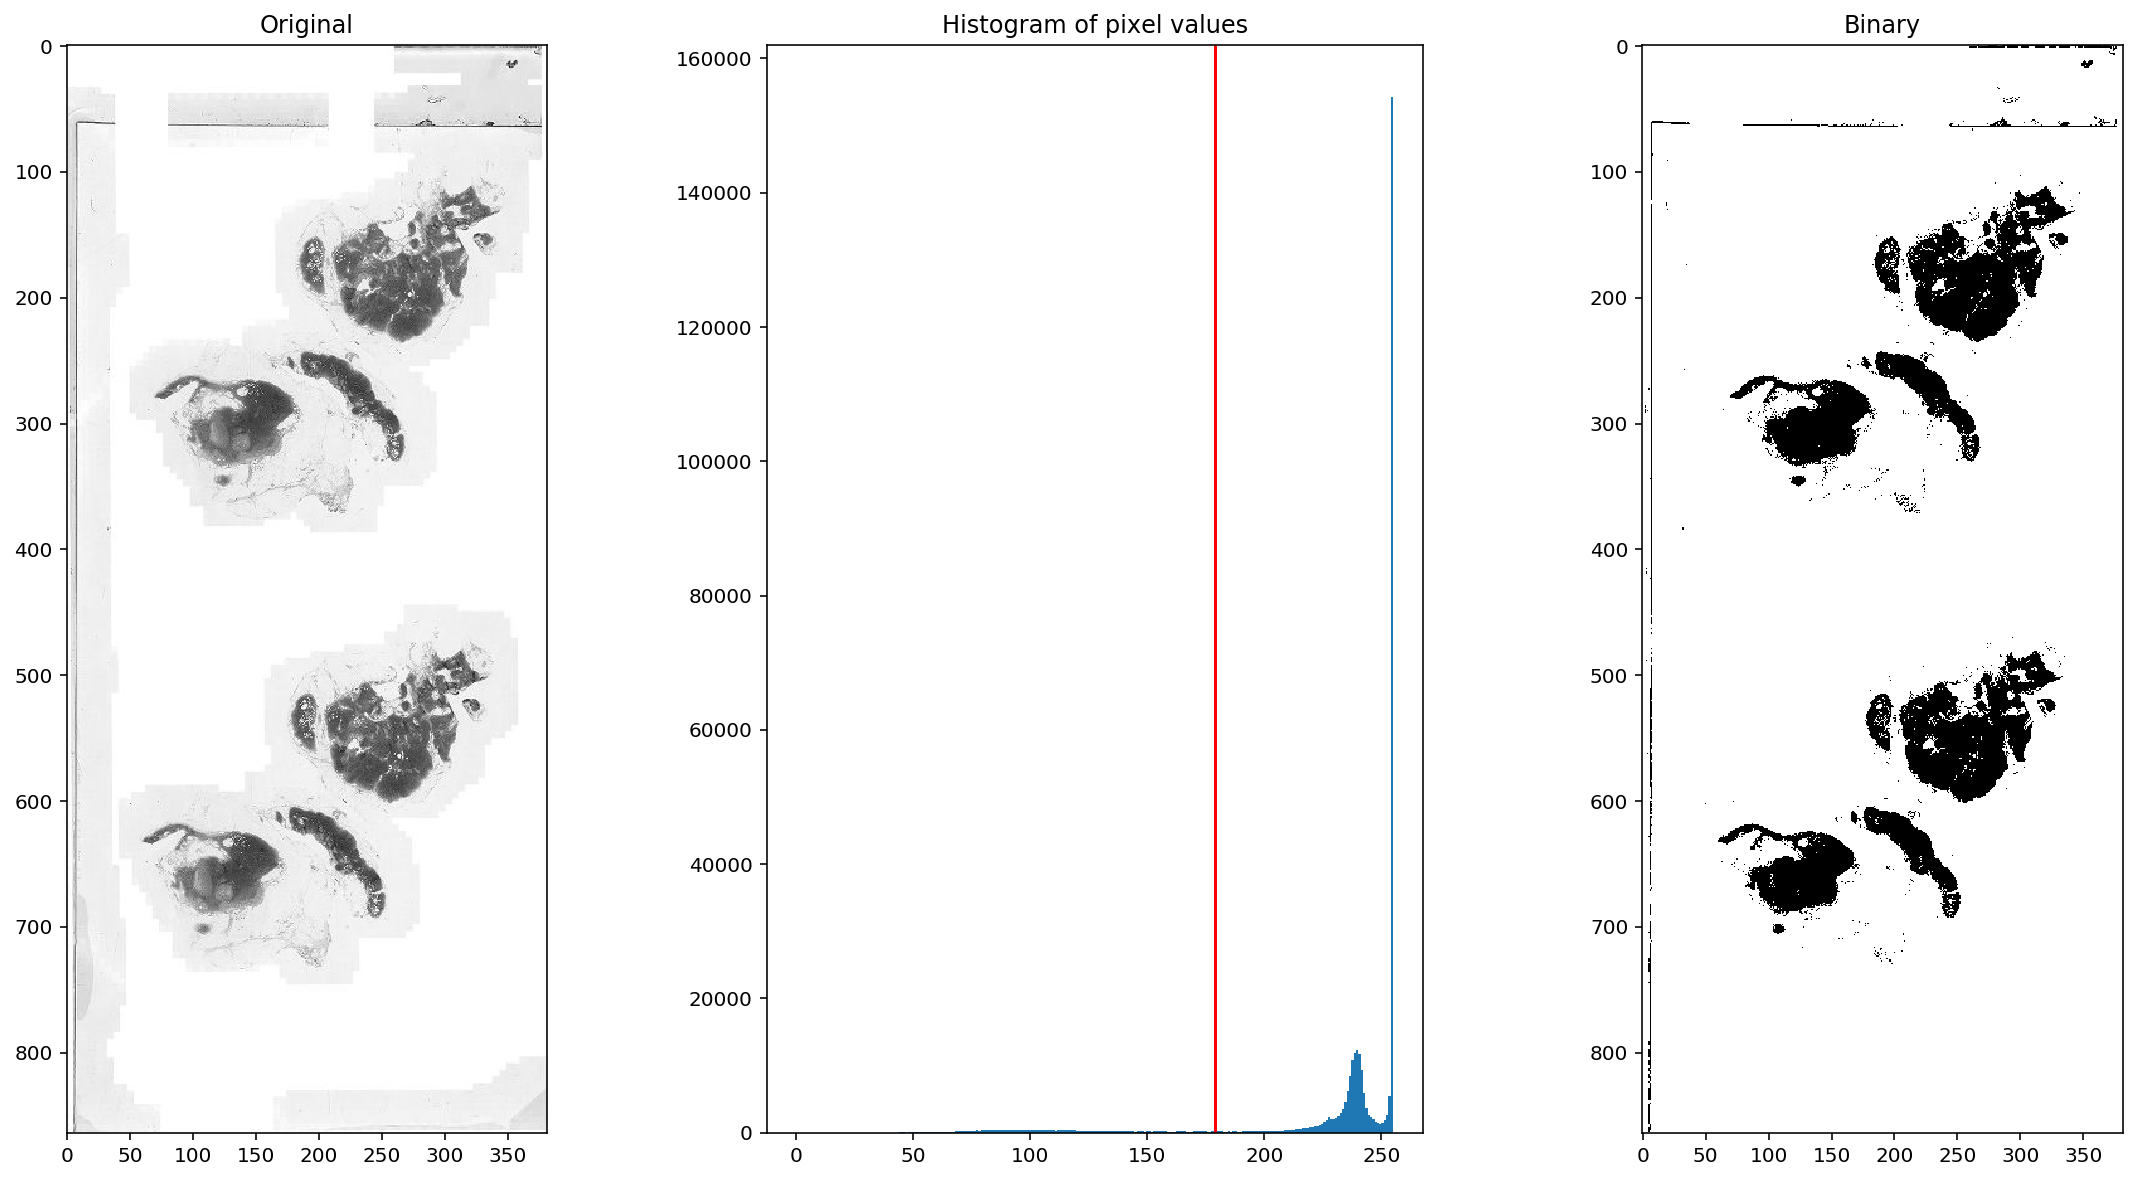

In [56]:
f, axes = plt.subplots(1, 3, figsize=(20, 10));
ax = axes.ravel();
ax[0].imshow(img, cmap='gray');
ax[0].set_title('Original');
ax[1].hist(img.ravel(), bins=256);
ax[1].set_title('Histogram of pixel values');
ax[1].axvline(thresh, color='r');
ax[2].imshow(binary, cmap='gray');
ax[2].set_title('Binary');

## Example Patches

In [57]:
from openslide.deepzoom import DeepZoomGenerator 

tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)

In [58]:
# f, axes = plt.subplots(3, 2, figsize=(20, 10))
# axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (100, 680)));
# axes[0, 0].set_title('Tumor Example');
# axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (100, 680)));
# axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
# axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (97, 693)));
# axes[1, 0].set_title('Normal Example');
# axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (97, 693)));
# axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
# axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (97, 692)));
# axes[2, 0].set_title('Tumor/Normal Boundary Example');
# axes[2, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (97, 692)));
# axes[2, 1].set_title('Truth mask (white=tumor, black=not_tumor)');
# plt.tight_layout();

The boundary example will probably be challenging to predict correctly.

## Data generator

In [59]:
def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR, filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    """
    base_truth_dir = Path(base_truth_dir)
    slide_contains_tumor = osp.basename(slide_path).startswith('Tumor_')
    
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.get_thumbnail((slide.dimensions[0] // 256, 848))

    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale\

    thresh = threshold_otsu(thumbnail_grey)

    binary = thumbnail_grey > thresh

    patches = pd.DataFrame(pd.DataFrame(binary).stack())

    patches['is_tissue'] = ~patches[0]
    patches.drop(0, axis=1, inplace=True)
    patches['slide_path'] = slide_path
    if slide_contains_tumor:
        truth_slide_path = base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif')
        print("truth_slide_path ",truth_slide_path)
        with openslide.open_slide(str(truth_slide_path)) as truth:
            thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)

        samples = pd.concat([patches, patches_y], axis=1)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue
    samples['tile_loc'] = list(samples.index)
    samples.reset_index(inplace=True, drop=True)
    return samples 

In [60]:
patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())

In [61]:
all_tissue_samples = find_patches_from_slide(slide_path)
print('Total patches in slide: %d' % len(all_tissue_samples))
all_tissue_samples.iloc[:10]
all_tissue_samples.is_tumor.value_counts()

truth_slide_path  /home/tee/Documents/thesis/camelyon16/center_3/Tumor_018_Mask.tif
Total patches in slide: 29064


is_tissue                                         slide_path  is_tumor  \
0      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
1      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
2      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
3      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
4      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
5      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
6      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
7      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
8      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   
9      True  /home/tee/Documents/thesis/camelyon16/center_3...     False   

   tile_loc  
0  (0, 260)  
1  (0, 261)  
2  (0, 269)  
3  (0, 270)  
4  (0, 271)  
5  (0, 272)  
6  (0, 273)  
7  (0, 274)  
8  (0, 275)  
9  (0, 280)

False    28377
True       687
Name: is_tumor, dtype: int64

In [62]:
import cv2
import os
from keras.utils.np_utils import to_categorical
import matplotlib.image as mpimg
NUM_CLASSES = 2 # not_tumor, tumor

def assure_path_exists(path):
        print("selected path",path)
        dir = os.path.dirname(path)
        if not os.path.exists(dir):
                print("making dir")
                os.makedirs(dir)


# patches_dir=str(BASE_TRUTH_DIR)+'/patches_'+slide_name+'/'
# patches_dir=str(BASE_TRUTH_DIR)+'/patches_Tumor_110.tif/'
patches_dir='/home/tee/Documents/thesis/camelyon16/center_13/patches_Tumor_018.tif/'



assure_path_exists(patches_dir)
                
def gen_imgs(samples, batch_size, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    global global_counter
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for counter, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = osp.basename(batch_sample.slide_path).startswith('Tumor_')
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    
                    if(os.path.isfile(str(patches_dir)+str(batch_sample.tile_loc[::-1]) +'.png') ):
                    
                        img=cv2.imread(str(patches_dir)+str(batch_sample.tile_loc[::-1]) +'.png')
                        b,g,r = cv2.split(img)       # get b,g,r
                        img = cv2.merge([r,g,b])     # switch it to rgb
#                         print("image was loaded")
#                         print(np.array(img))
#                         exit()
                    else:   
                        img = tiles.get_tile(tiles.level_count-1, batch_sample.tile_loc[::-1])
                        cv2.imwrite(str(patches_dir)+str(batch_sample.tile_loc[::-1]) +'.png',cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    truth_slide_path = base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif')
                    with openslide.open_slide(str(truth_slide_path)) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                else:
                    mask = np.zeros((256, 256))
                
#                 cv2.imwrite('patches/'+str(batch_sample.tile_loc[::-1]) +'.png',cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

#                 cv2.imwrite('patches/'+str(global_counter) +'.png',cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))
#                 cv2.imwrite('masks/'+str(global_counter) +'.png', mask)
#                 global_counter=global_counter+1
                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 256, 256, 2)
            yield X_train, y_train

selected path /home/tee/Documents/thesis/camelyon16/center_13/patches_Tumor_018.tif/


Note:
>Our model output and label tensors are of shape batch_sizex256x256x2.  So for each pixel we have a probability that they belong to class [not_tumor, tumor].  Label tensors are binary [0, 1].

In [63]:
sample_gen = gen_imgs(all_tissue_samples.sample(32, random_state=42), 32, shuffle=False)

In [64]:
global_counter=0

In [65]:
%time example_X, example_y  = next(sample_gen)

CPU times: user 1.73 s, sys: 132 ms, total: 1.86 s
Wall time: 2.73 s


In [66]:
print("global_counter",global_counter)

global_counter 0


In [67]:
example_X.shape

(32, 256, 256, 3)

In [68]:
example_y.shape

(32, 256, 256, 2)

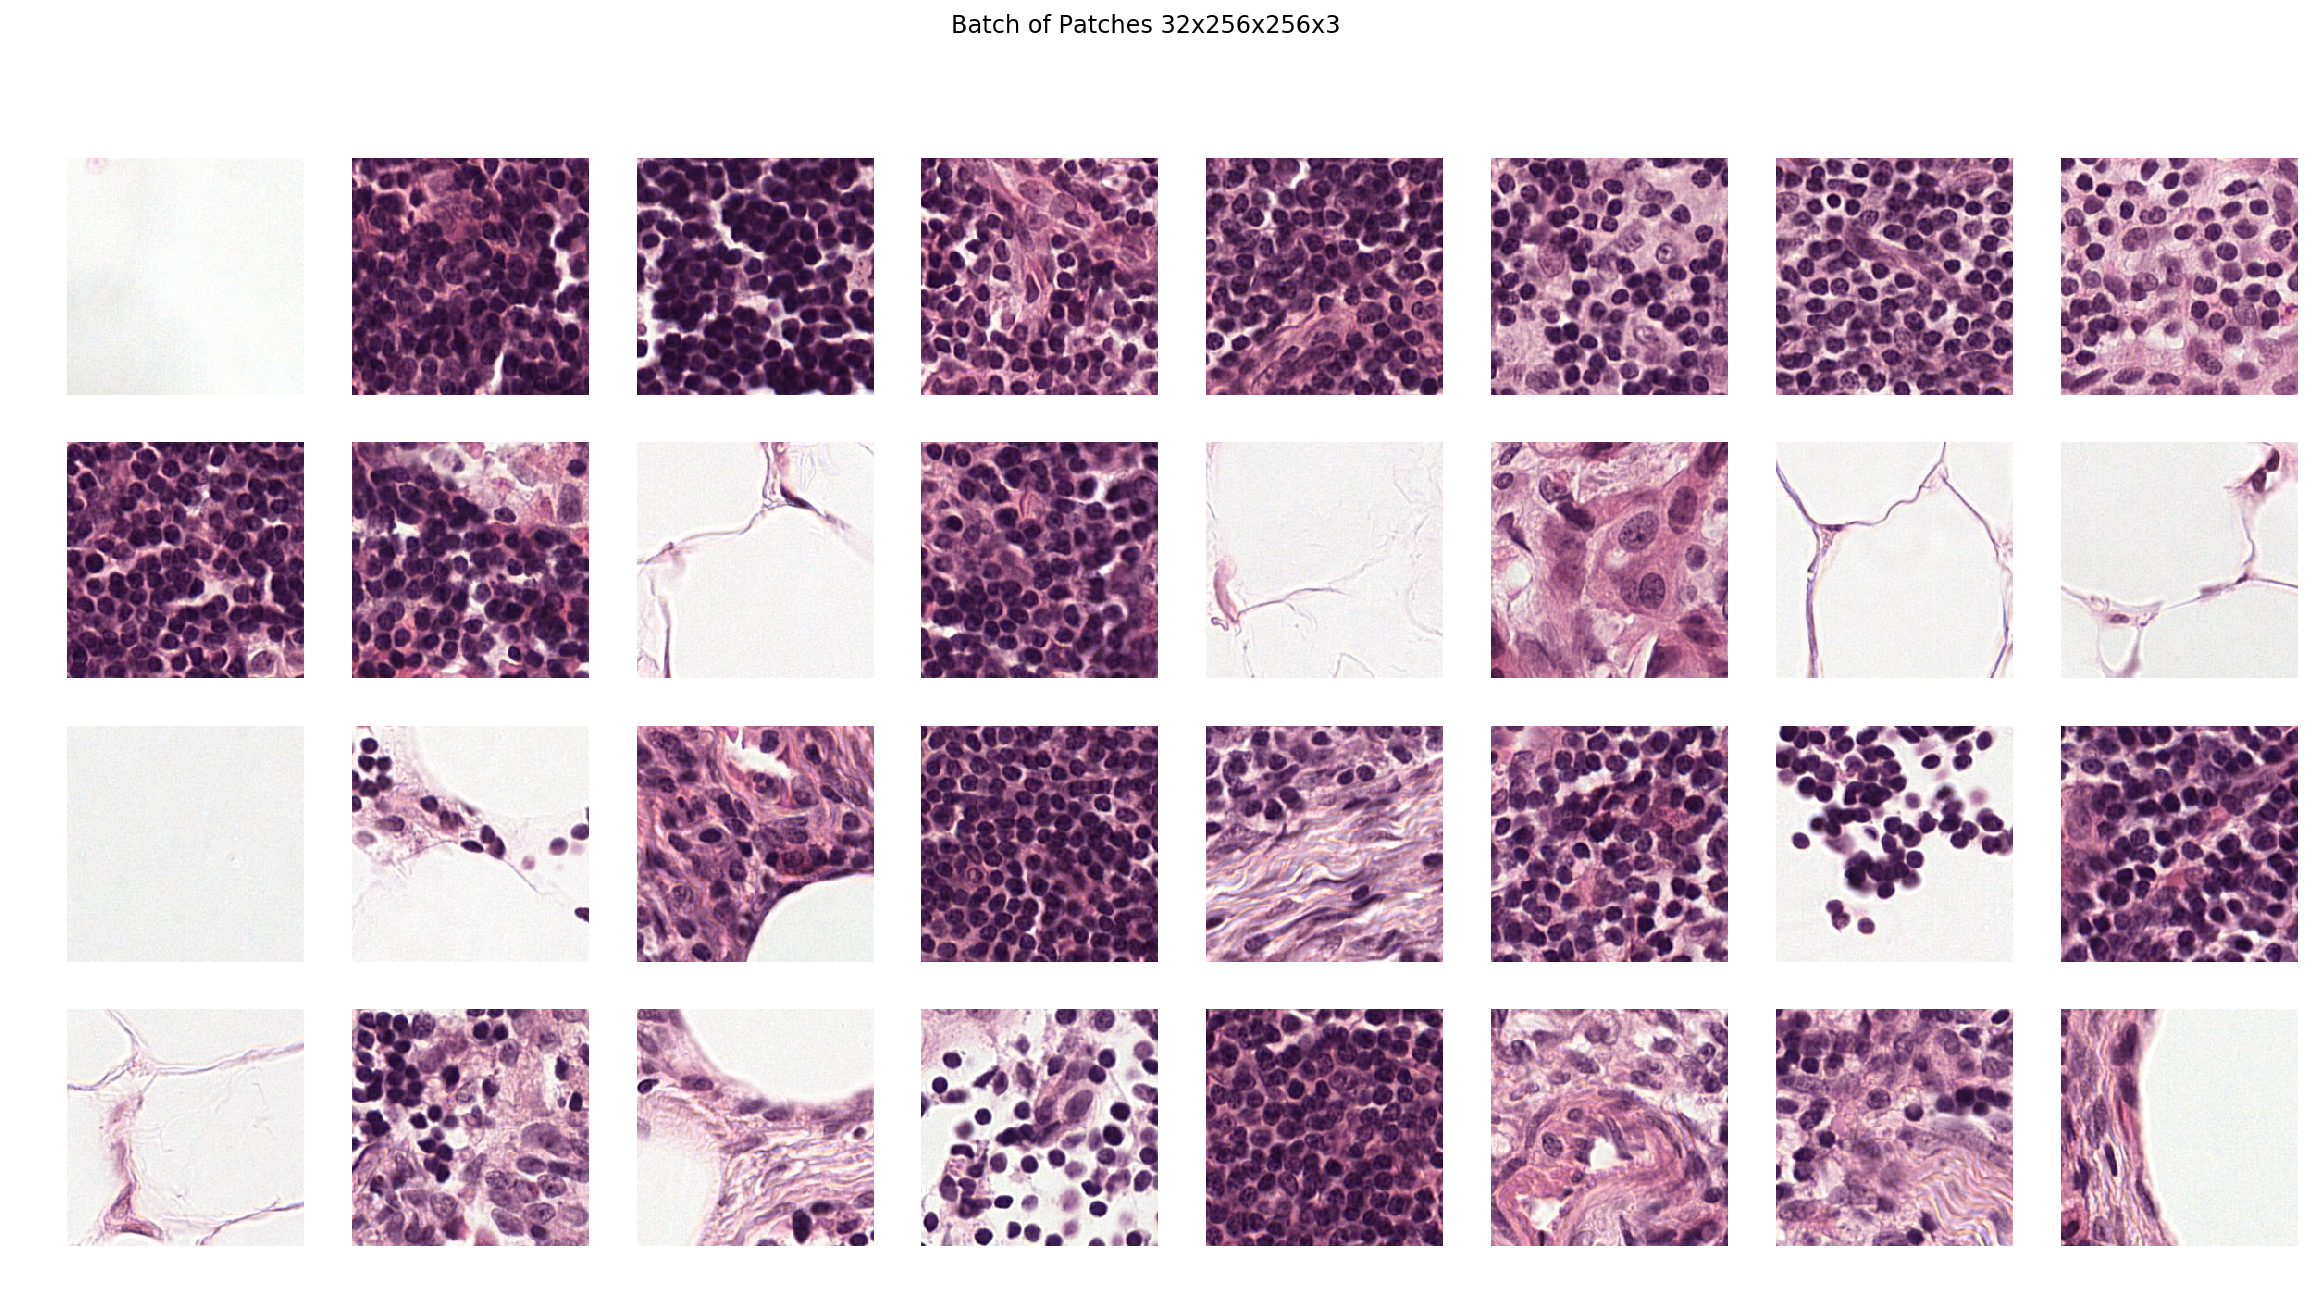

In [69]:
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

## Define network

This first image segmentation model is based on a fully convolutional network used to predict the left ventricle from cardiac MRI scans (described [here](https://gist.github.com/ajsander/b65061d12f50de3cef5d#file-fcn_tutorial-ipynb)).

Architecture:

0. Lambda, Normalize input (x / 255.0 - 0.5), outputs 256x256x3
1. Convolution1, 5 x 5 kernel, stride 2, outputs 128x128x100
2. Maxpooling1, 2 x 2 window, stride 2, outputs 64x64x100
3. Convolution2, 5 x 5 kernel, stride 2, outputs 32x32x200
4. Maxpooling2, 2 x 2 window, stride 2, outputs 16x16x200
5. Convolution3, 3 x 3 kernel, stride 1, outputs 16x16x300
6. Convolution4, 3 x 3 kernel, stride 1, outputs 16x16x300
7. Dropout, 0.1 rate
8. Convolution5, 1x1 kernel, stride 1, outputs 16x16x2
9. Deconvolution, 31 x 31 kernel, stride 16, outputs 256x256x2

This network is 6 layers deep with 1.8 M trainable parameters.

In [21]:
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
model.add(Convolution2D(100, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 100)     7600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 300)       810300    
__________

Note:
> Some model details.  We're using ELU activations instead of RELU units.  I've seen better performance with these, and they address the vanishing gradient problem LINK.
There's a dropout layer after our main conv layers.  We're using cross-entropy of our softmax predictions as our loss function to measure model performance.  Lastly, we use the ADAM optimizer because I'm lazy and I don't want to deal with tuning learning-rate knobs.

## Train model

In [23]:
BATCH_SIZE = 32
N_EPOCHS = 10

NUM_SAMPLES = 10000

In [24]:
samples = find_patches_from_slide(slide_path)
samples = samples.sample(NUM_SAMPLES, random_state=42)
samples.reset_index(drop=True, inplace=True)

truth_slide_path  /home/tee/Documents/thesis/camelyon16/center_2/Tumor_110_Mask.tif


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

# split samples into train and validation set
# use StratifiedShuffleSplit to ensure both sets have same proportions of tumor patches
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [26]:
#  global_counter=0

# from datetime import datetime

# ## TODO Add checkpoint mechanism to save old model before generating new

# train_generator = gen_imgs(train_samples, BATCH_SIZE)
# validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

# # Train model
# train_start_time = datetime.now()

# model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
#     validation_data=validation_generator,
#     validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
#     epochs=N_EPOCHS)

# train_end_time = datetime.now()
# print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))

# model.save(str(slide_name)+str('.h5'))

In [27]:
# # Save model
from keras.models import load_model
model = load_model('camelyon16_center_3_slide_9.h5')


## Evaluate model

### Predict single patches

In [28]:
# def predict_from_model(patch, model):
#     """Predict which pixels are tumor.
    
#     input: patch: 256x256x3, rgb image
#     input: model: keras model
#     output: prediction: 256x256x1, per-pixel tumor probability
#     """
    
#     prediction = model.predict(patch.reshape(1, 256, 256, 3))
#     prediction = prediction[:, :, :, 1].reshape(256, 256)
#     return prediction

In [29]:
# import matplotlib.gridspec as gridspec

# def plot_blend(patch, prediction, ax, alpha=0.75):
#     """alpha blend patch and prediction.
#     https://matplotlib.org/examples/pylab_examples/layer_images.html
    
#     input: patch: 256x256x3, rgb image
#     input: prediction: 256x256x1, per-pixel tumor probability
#     input: ax: maplotlib Axes object
#     input: alpha: alpha blend
#     """
    
#     dx, dy = 0.05, 0.05
#     x = np.arange(0, patch.shape[1] - 1, dx)
#     y = np.arange(0, patch.shape[0] - 1, dy)
#     xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
#     extent = xmin, xmax, ymin, ymax

#     # fig = plt.figure(frameon=False, figsize=(10, 5))
#     Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
#     Z2 = prediction

#     im1 = ax.imshow(Z1, cmap='gray', extent=extent)
#     im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
#                      extent=extent)
#     ax.axis('off');

# def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
#     """
#     input: patch: 256x256x3, rgb image
#     input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
#     input: prediction: 256x256x1, per-pixel tumor probability
#     """
#     gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
#     ax0 = plt.subplot(gs[0, 0])
#     ax1 = plt.subplot(gs[0, 1])
#     ax2 = plt.subplot(gs[1, 0])
#     ax3 = plt.subplot(gs[1, 1])
#     ax4 = plt.subplot(gs[:, 2])
#     axc = plt.subplot(gs[:, 3])

#     ax0.imshow(patch);
#     ax0.set_title('Original')
    
#     ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
#     ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
#     p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
#     ax2.set_title('Prediction heatmap')

#     ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
#     ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
#     plot_blend(patch, prediction, ax4, alpha)
#     ax4.set_title('Original+Prediction blend')
    
#     fig = plt.gcf()
#     fig.set_size_inches(20, 10)
#     fig.suptitle(title_str)
#     fig.colorbar(p, cax=axc, orientation="vertical")
#     axc.set_title('Probability pixel is tumor')

#### Easy tumor patch

In [30]:
# example_patch = example_X[-3]
# example_truth = example_y[-3]

# prediction = predict_from_model(example_patch, model)
# plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

These calls look good.  Easy all tumor case.

In [31]:
# pred_s = pd.Series(prediction.flatten())
# print(pred_s.describe())
# ax = pred_s.hist(bins=100);
# ax.set_title('Example patch pixel predictions');
# ax.set_ylabel('Count');
# ax.set_xlabel('Probability pixel is tumor');

#### Easy normal patch

In [32]:
# example_patch = example_X[16]
# example_truth = example_y[16]

# prediction = predict_from_model(example_patch, model)
# plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

Normal case called correctly.

In [33]:
# pred_s = pd.Series(prediction.flatten())
# print(pred_s.describe())
# ax = pred_s.hist(bins=100);
# ax.set_title('Example patch pixel predictions');
# ax.set_ylabel('Count');
# ax.set_xlabel('Probability pixel is tumor');

#### Tough border patch

In [34]:
# example_patch = example_X[1]
# example_truth = example_y[1]

# prediction = predict_from_model(example_patch, model)
# plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

The model is predicting more tumor than expected.  I could see why it would be thinking the upper portion is cancer.

In [35]:
# pred_s = pd.Series(prediction.flatten())
# print(pred_s.describe())
# ax = pred_s.hist(bins=100);
# ax.set_title('Example patch pixel predictions');
# ax.set_ylabel('Count');
# ax.set_xlabel('Probability pixel is tumor');

#### Tough normal patch

In [36]:
# example_patch = example_X[-13]
# example_truth = example_y[-13]

# prediction = predict_from_model(example_patch, model)
# plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

To my untrained eye, this looks like our model is correctly picking up a contiguous sliver of cancer cells.

In [37]:
# pred_s = pd.Series(prediction.flatten())
# print(pred_s.describe())
# ax = pred_s.hist(bins=100);
# ax.set_title('Example patch pixel predictions');
# ax.set_ylabel('Count');
# ax.set_xlabel('Probability pixel is tumor');

In [38]:
# def get_random_patch_from_samples(samples, random_state=None):
#     X_i, y_i = next(gen_imgs(samples.sample(1, random_state=random_state), 1))
#     return X_i, y_i

# X_i, y_i = get_random_patch_from_samples(all_tissue_samples)
# pred_i = predict_from_model(X_i, model)
# plot_patch_with_pred(X_i[0], y_i[0], pred_i, title_str='Random Patch')

### Calculate Perfomance Metrics

In [39]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions

validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

confusion_mtx = np.zeros((2, 2))

for i in tqdm(range(int(validation_steps))):
    X, y  = next(validation_generator)
    preds = predict_batch_from_model(X, model)
    
    y_true = y[:, :, :, 1].ravel()
    y_pred = np.uint8(preds > 0.5).ravel()
    
    confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])

100%|██████████| 63/63 [13:41<00:00, 13.04s/it]


In [40]:
confusion_mtx

array([[  6.57052290e+07,   1.63300000e+03],
       [  6.53641920e+07,   9.46000000e+02]])

In [41]:
tn = confusion_mtx[0, 0]
fp = confusion_mtx[0, 1]
fn = confusion_mtx[1, 0]
tp = confusion_mtx[1, 1]

print(tp)
print(tp+fn)

946.0
65365138.0


In [42]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("F1 Score: %.2f" % f1_score)

Accuracy: 0.50
Recall: 0.00
Precision: 0.37
F1 Score: 0.00


### Predict whole slide

In [43]:
# all_samples = find_patches_from_slide(slide_path, filter_non_tissue=False)
# print('Total patches in slide: %d' % len(all_samples))
# all_samples.iloc[:5]
# all_samples.is_tumor.value_counts()

In [44]:
# from matplotlib import cm
# from tqdm import tqdm

# output_dir = Path('/home/ubuntu/data/viewers/Tumor_009/slide_files/18')

# alpha = 0.5

# n_samples = len(all_samples)
# n_cols = int(slide.dimensions[0] / 256)
# n_rows = int(slide.dimensions[1] / 256)
# assert n_cols * n_rows == n_samples

# thumbnail = slide.get_thumbnail((n_cols, n_rows))
# thumbnail = np.array(thumbnail)

# # batch_size = n_cols
# batch_size = 32
# output_thumbnail_preds = list()
    
# for offset in tqdm(list(range(0, n_samples, batch_size))):
#     batch_samples = all_samples.iloc[offset:offset+batch_size]
#     png_fnames = batch_samples.tile_loc.apply(lambda coord: str(output_dir / ('%d_%d.png' % coord[::-1])))
    
#     X, _ = next(gen_imgs(batch_samples, batch_size, shuffle=False))
    
#     if batch_samples.is_tissue.nunique() == 1 and batch_samples.iloc[0].is_tissue == False:
#         # all patches in this row do not have tissue, skip them all
#         output_thumbnail_preds.append(np.zeros(batch_size, dtype=np.float32))
        
#         # output pngs
#         for i, png_fname in enumerate(png_fnames):
#             plt.imsave(png_fname, X[i])
#     else:
#         # make predictions
#         preds = predict_batch_from_model(X, model)
#         output_thumbnail_preds.append(preds.mean(axis=(1,2)))
        
#         # overlay preds
#         # save blended imgs
#         for i, png_fname in enumerate(png_fnames):
#             pred_i = preds[i]
#             X_i = X[i]
#             output_img = cv2.cvtColor(X_i, cv2.COLOR_RGB2GRAY)
#             output_img2 = cv2.cvtColor(output_img.copy(), cv2.COLOR_GRAY2RGB)

#             overlay = np.uint8(cm.jet(pred_i) * 255)[:,:,:3]
#             blended = cv2.addWeighted(overlay, alpha, output_img2, 1-alpha, 0, output_img)
            
#             plt.imsave(png_fname, blended)
        

# output_thumbnail_preds = np.array(output_thumbnail_preds)

In [45]:
# output_thumbnail_preds = output_thumbnail_preds.reshape(n_rows, n_cols)
# truth = openslide.open_slide(truth_path)

In [46]:
# f, axes = plt.subplots(1, 2, figsize=(40, 18))
# ax = axes.flatten()
# plot_blend(thumbnail, output_thumbnail_preds, ax=ax[0])

# thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 
# ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
# ax[0].set_title('Original+Predictions blend')
# ax[1].set_title('Truth')
# ax[1].axis('off');
# plt.tight_layout();

Final predictions for whole slide highlight 4 main tumor lesions in slide.